<a href="https://colab.research.google.com/github/AkkiNikumbh/ML-EXPERIMENTS/blob/main/AkashSingh_Experiment_9_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn matplotlib numpy

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
# Activation and loss functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def sigmoid_derivative(a):
    return a * (1 - a)
def relu(z):
    return np.maximum(0, z)
def relu_derivative(z):
    return (z > 0).astype(float)
def compute_bce_loss(y, y_hat):
    epsilon = 1e-15
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    m = y.shape[1]
    return -np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) / m

class SimpleNN:
    def __init__(self, layer_dims, learning_rate=0.01, n_iterations=2000):
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.costs = []
        self.parameters = self.initialize_parameters()

    def initialize_parameters(self):
        np.random.seed(42)
        parameters = {}
        L = len(self.layer_dims)
        for l in range(1, L):
            parameters['W'+str(l)] = np.random.randn(self.layer_dims[l], self.layer_dims[l-1]) * 0.01
            parameters['b'+str(l)] = np.zeros((self.layer_dims[l], 1))
        return parameters

    def forward(self, X):
        A = X
        cache = {'A0': X}
        L = len(self.layer_dims) - 1
        for l in range(1, L):
            W = self.parameters['W'+str(l)]
            b = self.parameters['b'+str(l)]
            Z = np.dot(W, A) + b
            A = relu(Z)
            cache['Z'+str(l)] = Z
            cache['A'+str(l)] = A
        # Output layer (sigmoid)
        W = self.parameters['W'+str(L)]
        b = self.parameters['b'+str(L)]
        Z = np.dot(W, A) + b
        A = sigmoid(Z)
        cache['Z'+str(L)] = Z
        cache['A'+str(L)] = A
        return A, cache

    def backward(self, X, y, cache):
        m = X.shape[1]
        grads = {}
        L = len(self.layer_dims) - 1
        y = y.reshape(1, -1)
        A_final = cache['A'+str(L)]
        dA = -(np.divide(y, A_final) - np.divide(1 - y, 1 - A_final))
        # Output layer (sigmoid)
        dZ = dA * sigmoid_derivative(A_final)
        A_prev = cache['A'+str(L-1)]
        grads['dW'+str(L)] = (1/m) * np.dot(dZ, A_prev.T)
        grads['db'+str(L)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(self.parameters['W'+str(L)].T, dZ)
        # Hidden layers (ReLU)
        for l in reversed(range(1, L)):
            dZ = dA_prev * relu_derivative(cache['Z'+str(l)])
            A_prev = cache['A'+str(l-1)]
            grads['dW'+str(l)] = (1/m) * np.dot(dZ, A_prev.T)
            grads['db'+str(l)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dA_prev = np.dot(self.parameters['W'+str(l)].T, dZ)
        return grads

    def update_parameters(self, grads):
        L = len(self.layer_dims) - 1
        for l in range(1, L+1):
            self.parameters['W'+str(l)] -= self.learning_rate * grads['dW'+str(l)]
            self.parameters['b'+str(l)] -= self.learning_rate * grads['db'+str(l)]

    def fit(self, X, y):
        for i in range(self.n_iterations):
            Y_hat, cache = self.forward(X)
            loss = compute_bce_loss(y, Y_hat)
            grads = self.backward(X, y, cache)
            self.update_parameters(grads)
            self.costs.append(loss)
            if i % 500 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")

    def predict(self, X):
        A, _ = self.forward(X)
        return (A > 0.5).astype(int).flatten()


Iteration 0, Loss: 0.6932
Iteration 500, Loss: 0.6597
Iteration 1000, Loss: 0.6574
Iteration 1500, Loss: 0.0636


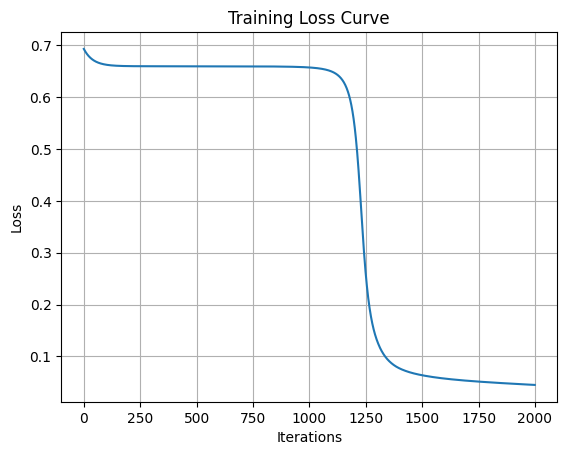

Training Accuracy: 98.46%
Test Accuracy: 99.12%


In [11]:
# --- Data Preparation ---
data = load_breast_cancer()
X = data.data
y = data.target

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transpose for our implementation (features x samples)
X_train = X_train.T
y_train = y_train.reshape(1, -1)
X_test = X_test.T
y_test = y_test.reshape(1, -1)

# --- Training ---
layer_dims = [X_train.shape[0], 16, 8, 1]  # Two hidden layers with 16 and 8 units
model = SimpleNN(layer_dims, learning_rate=0.05, n_iterations=2000)
model.fit(X_train, y_train)

# --- Plot Loss ---
plt.plot(model.costs)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# --- Display Accuracy ---
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("Training Accuracy: {:.2f}%".format(100*np.mean(train_pred == y_train.flatten())))
print("Test Accuracy: {:.2f}%".format(100*np.mean(test_pred == y_test.flatten())))
